In [3]:
import os
import tempfile

from torch.utils.data import DataLoader

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

from tqdm import tqdm

In [ ]:
data_root = tempfile.gettempdir()
naip_root = os.path.join(data_root, "naip")
naip_url = (
    "https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/"
)
tiles = [
    "m_3807511_ne_18_060_20181104.tif",
    "m_3807511_se_18_060_20181104.tif",
    "m_3807512_nw_18_060_20180815.tif",
    "m_3807512_sw_18_060_20180815.tif",
]
for tile in tiles:
    download_url(naip_url + tile, naip_root)

naip = NAIP(naip_root)

In [16]:
import torchvision.transforms as T
from typing import Sequence,Callable,Union,Any,Tuple,List
import numpy as np
import torch

class Compose(T.Compose):
    """ Custom Compose which processes a list of inputs """
    def __init__(self, transforms: Sequence[Callable]):
        self.transforms = transforms

    def __call__(self, x: Union[Any, Sequence]):
        if isinstance(x, Sequence):
            for t in self.transforms:
                x = [t(i) for i in x]
        else:
            for t in self.transforms:
                x = t(x)
        return x
    
class ToTensor(object):
    """ Custom ToTensor op which doesn't perform min-max normalization """
    def __init__(self, permute_dims: bool = True):
        self.permute_dims = permute_dims

    def __call__(self, x: np.ndarray) -> torch.Tensor:

        if x.dtype == "uint16":
            x = x.astype("int32")

        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)

        if x.ndim == 2:
            if self.permute_dims:
                x = x[:, :, None]
            else:
                x = x[None, :, :]

        # Convert HWC->CHW
        if self.permute_dims:
            if x.ndim == 4:
                x = x.permute((0, 3, 1, 2)).contiguous()
            else:
                x = x.permute((2, 0, 1)).contiguous()

        return x

In [22]:
import os
from glob import glob
from typing import List, Dict

import torch
import numpy as np
from PIL import Image

class GID15(torch.utils.data.Dataset):
    """ Gaofen Image Dataset (GID-15) from 'Land-Cover Classification with High-Resolution
    Remote Sensing Images Using Transferable Deep Models', Tong et al. (2018)
    https://arxiv.org/abs/1807.05713

    'We construct a new large-scale land-cover dataset with Gaofen-2 (GF-2) satellite
    images. This new dataset, which is named as Gaofen Image Dataset with 15 categories
    (GID-15), has superiorities over the existing land-cover dataset because of its
    large coverage, wide distribution, and high spatial resolution. The large-scale
    remote sensing semantic segmentation set contains 150 pixel-level annotated GF-2
    images, which is labeled in 15 categories.'
    """
    classes = [
        "background",
        "industrial_land",
        "urban_residential",
        "rural_residential",
        "traffic_land",
        "paddy_field",
        "irrigated_land",
        "dry_cropland",
        "garden_plot",
        "arbor_woodland",
        "shrub_land",
        "natural_grassland",
        "artificial_grassland",
        "river",
        "lake",
        "pond"
    ]
    splits = ["train", "val", "test"]

    def __init__(
        self,
        root: str = ".data/gid-15",
        split: str = "train",
        transform: Compose = Compose([ToTensor()]),
    ):
        self.split = split
        self.transform = transform
        self.images = self.load_images(os.path.join(root, "GID"), split)

    @staticmethod
    def load_images(path: str, split: str) -> List[Dict]:
        images = sorted(glob(os.path.join(path, "img_dir", split, "*.tif")))
        if split in ["train", "val"]:
            masks = [
                image.replace("img_dir", "ann_dir").replace(".tif", "_15label.png")
                for image in images
            ]
        else:
            masks = [None] * len(images)

        files = [dict(image=image, mask=mask) for image, mask in zip(images, masks)]
        return files

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Dict:
        image_path, mask_path = self.images[idx]["image"], self.images[idx]["mask"]
        x = np.array(Image.open(image_path))

        if self.split in ["train", "val"]:
            y = np.array(Image.open(mask_path))
            x, y = self.transform([x, y])
            output = dict(x=x, mask=y)
        else:
            x = self.transform(x)
            output = dict(x=x)

        return output

In [24]:
root=r'E:\data\GID\Fine Land-cover Classification_15classes'

transform=Compose([ToTensor()])
dataset=GID15(
    root=root,
    split="train",  # or 'val', 'test'
    transform=transform
)

In [92]:
def raster_projection_update_batch(src_root,dst_root,crs,suffix=None):
    import rasterio as rio
    from tqdm import tqdm
    import glob
    import os
    from pathlib import Path  
    
    if suffix:
        fns=glob.glob(os.path.join(src_root,'*.{}'.format(suffix)))
    else:
        fns=glob.glob(os.path.join(src_root,'*.*'))
    
    for fn in tqdm(fns[:1]):
        with rio.open(fn,'r+') as src:   
            #src.crs=crs
            profile=src.profile
            profile.update(crs=crs)
            bands=src.read()          
        
        with rio.open(os.path.join(dst_root,Path(fn).name),'w',**profile) as dst:
            dst.write(bands)  
        
raster_projection_update_batch(args.data.gid5_image_NirRGB,args.data.gid5_image_NirRGB_prj,crs=4480,suffix='tif')    

  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'affine'

In [ ]:
import geopandas as gpd
ch_provincial_borders=gpd.read_file(args.data.CH_provincial_borders_fn)
proj_Krasovsky_1940_Albers=ch_provincial_borders.crs
__C.gi=AttrDict()
__C.gi.Krasovsky_1940_Albers=proj_Krasovsky_1940_Albers

In [83]:
from util_misc import AttrDict
__C=AttrDict() 
args=__C

__C.data=AttrDict()
__C.data.CH_provincial_borders_fn='./data/CN-sheng-A/CN-sheng-A.shp'

__C.data.gid5_image_RGB=r'E:\data\GID\Large-scale Classification_5classes\image_RGB'
__C.data.gid5_image_NirRGB=r'E:\data\GID\Large-scale Classification_5classes\image_NirRGB'
__C.data.gid5_label=r'E:\data\GID\Large-scale Classification_5classes\label_5classes'

__C.data.gid5_image_RGB_prj=r'E:\data\GID\Large-scale Classification_5classes\image_RGB_prj'
__C.data.gid5_image_NirRGB_prj=r'E:\data\GID\Large-scale Classification_5classes\image_NirRGB_prj'
__C.data.gid5_label_prj=r'E:\data\GID\Large-scale Classification_5classes\label_5classes_prj'

In [ ]:
import geopandas as gpd
ch_provincial_borders=gpd.read_file(args.data.CH_provincial_borders_fn)
proj_Krasovsky_1940_Albers=ch_provincial_borders.crs
__C.gi=AttrDict()
__C.gi.Krasovsky_1940_Albers=proj_Krasovsky_1940_Albers

In [94]:
def raster_projection_update_batch(src_root,dst_root,crs,suffix=None):
    import rasterio as rio
    from tqdm import tqdm
    import glob
    import os
    from pathlib import Path  
    
    if suffix:
        fns=glob.glob(os.path.join(src_root,'*.{}'.format(suffix)))
    else:
        fns=glob.glob(os.path.join(src_root,'*.*'))
    
    for fn in tqdm(fns[:1]):
        with rio.open(fn,'r+') as src:   
            #src.crs=crs
            profile=src.profile
            profile.update(crs=crs)
            bands=src.read()          

        with rio.open(os.path.join(dst_root,Path(fn).name),'w',**profile) as dst:
            dst.write(bands)  
        
raster_projection_update_batch(args.data.gid5_image_NirRGB,args.data.gid5_image_NirRGB_prj,crs=4480,suffix='tif')    

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


In [89]:
with rio.open(save_fn,'r+') as src:  
    bands=src.read()  


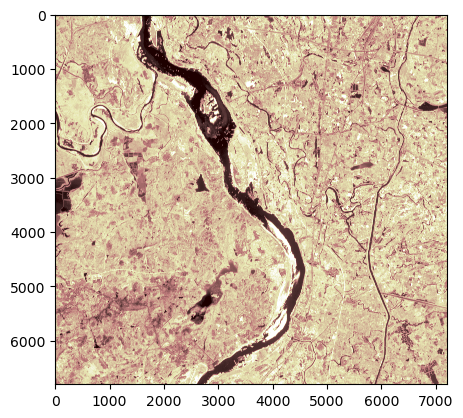

In [90]:
from matplotlib import pyplot
pyplot.imshow(bands[0], cmap='pink')
pyplot.show()  

In [95]:
from torchgeo.datasets import RasterDataset


class GF2(RasterDataset):
    filename_glob="GF2*.tif"
    # filename_regex = r"^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])"
    # date_format = "%Y%m%dT%H%M%S"
    is_image=True
    separate_files=False
    all_bands=["r", "g", "b", "nir"]
    rgb_bands=["r", "g", "b"]
    
dataset=GF2(args.data.gid5_image_NirRGB_prj)

C:\Users\richi\anaconda3\envs\usda\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


CPLE_AppDefinedError: The transformation is already "north up" or a transformation between pixel/line and georeferenced coordinates cannot be computed for E:/data/GID/Large-scale Classification_5classes/image_NirRGB_prj/GF2_PMS1__L1A0000564539-MSS1.tif. There is no affine transformation and no GCPs. Specify transformation option SRC_METHOD=NO_GEOTRANSFORM to bypass this check.

In [1]:
import networkx as nx
G = nx.complete_graph(5)
nx.draw(G)

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

因为涉及站点约有3.2万，如果使用下述代码计算会花费较长时间，因此在Spyder中通过`multiprocessing`库使用多线程计算，缩短计算时间，包含`station2park_mean_time_cost_pool`和`station2park_mean_time_cost`两个模块。

In [ ]:
__C.data.station2park_mean_time_cost_all_fn=r'E:\data\public_trans_network\station2park_mean_time_cost_all.pickle'

station2park_mean_time_cost_all={}
for node in tqdm(G_SB.nodes):
    station2park_mean_time_cost_all[node]={}
    for idx,row in comprehensivePark_adjacentStations.iterrows():
        adjacentStations=eval(row.adjacent_PointUid)
        node_min_sp_time_cost,_=nx.multi_source_dijkstra(G_SB,adjacentStations,node,weight='time_cost')
        station2park_mean_time_cost_all[node][row.Name_EN]=node_min_sp_time_cost
    
with open(args.data.station2park_mean_time_cost_all_fn,'wb') as f:
     pickle.dump(station2park_mean_time_cost_all,f)   

`station2park_mean_time_cost_pool.py`

In [ ]:
def station2park_mean_time_cost_single(node,args):
    import networkx as nx
    
    comprehensivePark_adjacentStations,G_SB=args
    
    station2park_mean_time_cost_park={}
    station2park_mean_time_cost_park[node]={}
    for idx,row in comprehensivePark_adjacentStations.iterrows():
        adjacentStations=eval(row.adjacent_PointUid)
        node_min_sp_time_cost,_=nx.multi_source_dijkstra(G_SB,adjacentStations,node,weight='time_cost')
        station2park_mean_time_cost_park[node][row.Name_EN]=node_min_sp_time_cost
        
    return station2park_mean_time_cost_park

`station2park_mean_time_cost.py`

In [ ]:
import pickle
from util_misc import AttrDict
from database import postSQL2gpd,gpd2postSQL
import warnings
warnings.filterwarnings('ignore')

__C=AttrDict() 
args=__C

__C.db=AttrDict() 
__C.db.UN='postgres'
__C.db.PW='123456'
__C.db.DB='public_transportation'
__C.db.GC='geometry' 
__C.db.db_info=dict(geom_col=args.db.GC,myusername=args.db.UN,mypassword=args.db.PW,mydatabase=args.db.DB)

__C.data=AttrDict()
__C.data.G_bus_stations="./data/network/G_bus_stations.gpickle"
__C.data.G_SB="./data/network/G_SB.gpickle"
__C.data.station2park_mean_time_cost_all_fn=r'E:\data\public_trans_network\station2park_mean_time_cost_all.pickle'


def station2park_mean_time_cost(G_SB,comprehensivePark_adjacentStations):
    from multiprocessing import Pool    
    from functools import partial
    import networkx as nx
    from functools import reduce
    from station2park_mean_time_cost_pool import station2park_mean_time_cost_single
    from tqdm import tqdm
    
    args=partial(station2park_mean_time_cost_single, args=[comprehensivePark_adjacentStations,G_SB])
    print('-'*50)
    with Pool(8) as p:
        results=tqdm(p.map(args,G_SB.nodes))
    
    results_dict=reduce(lambda a, b: {**a, **b}, results)
    
    return results_dict    

    
if __name__=="__main__":   
    comprehensivePark_adjacentStations=postSQL2gpd(table_name='adjacent_stations',**args.db.db_info)
    comprehensivePark_adjacentStations_copy=comprehensivePark_adjacentStations.copy(deep=True)    
    with open(args.data.G_SB,'rb') as f:
        G_SB=pickle.load(f)             
    
    station2park_mean_time_cost_all=station2park_mean_time_cost(G_SB,comprehensivePark_adjacentStations_copy)
    with open(args.data.station2park_mean_time_cost_all_fn,'wb') as f:
         pickle.dump(station2park_mean_time_cost_all,f) 